Dataset : https://drive.google.com/drive/folders/1ZDVv9fsCaD3FdCp8RaoKKGFPfvmWbayd?usp=drive_link



This code implements a few-shot learning model for wheat disease classification using EfficientNet for feature extraction and an attention module for similarity learning, trained with cross-entropy loss and evaluated for accuracy.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [62]:
# Define Dataset Class
class WheatDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [63]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [64]:
# Load Dataset and Split into Train/Test
def load_data(data_dir, train_split=0.8):
    """
    Load dataset and split into train and test.
    :param data_dir: Path to dataset where folders represent classes.
    :param train_split: Ratio of training data (default: 80% train, 20% test).
    :return: Train and test datasets.
    """
    classes = sorted(os.listdir(data_dir))  # Get class names
    image_paths = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(class_to_idx[cls])

    # Shuffle the dataset
    dataset = list(zip(image_paths, labels))
    random.shuffle(dataset)
    image_paths, labels = zip(*dataset)

    # Split into train and test
    train_size = int(train_split * len(image_paths))
    train_images, test_images = image_paths[:train_size], image_paths[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    return train_images, train_labels, test_images, test_labels, class_to_idx


In [65]:
# Load Data
dataset_path = "./D3_Final"  # Update this with your dataset path
train_images, train_labels, test_images, test_labels, class_to_idx = load_data(dataset_path)

train_dataset = WheatDataset(train_images, train_labels, transform=transform)
test_dataset = WheatDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [66]:
# Feature Extractor (EfficientNet)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        self.efficient_net.classifier = nn.Identity()  # Remove last layer

    def forward(self, x):
        return self.efficient_net(x)


In [67]:
class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        self.W1 = nn.Linear(feature_dim, feature_dim)
        self.W2 = nn.Linear(feature_dim, feature_dim)
        self.omega_x = nn.Parameter(torch.rand(feature_dim))
        self.omega_y = nn.Parameter(torch.rand(feature_dim))
        self.omega_xy = nn.Parameter(torch.rand(feature_dim))

    def forward(self, support, query):
        s = torch.relu(self.W1(support))
        q = torch.relu(self.W2(query))
        similarity = torch.sum(self.omega_x * s + self.omega_y * q + self.omega_xy * (s * q), dim=-1)

        # Ensure output matches EfficientNet feature size (1280)
        output = torch.relu(self.W1(support) + self.W2(query))
        return output  # Output must be (batch_size, 1280)


In [68]:
# Few-Shot Learning Network
class FewShotNetwork(nn.Module):
    def __init__(self, feature_dim=1280, num_classes=18):
        super(FewShotNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.attention = AttentionModule(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, support, query):
        support_features = self.feature_extractor(support)
        query_features = self.feature_extractor(query)
        similarity = self.attention(support_features, query_features)
        output = self.fc(similarity)
        return output


In [69]:
# Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FewShotNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


c:\Users\DELL\Documents\PFE\M3\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\Documents\PFE\M3\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# Training Loop
def train_model(model, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, images)  # Support and Query Set (same for now)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader)



Epoch [1/20], Loss: 0.4178
Epoch [2/20], Loss: 0.2325
Epoch [3/20], Loss: 0.1955
Epoch [4/20], Loss: 0.1096
Epoch [5/20], Loss: 0.1346
Epoch [6/20], Loss: 0.1880
Epoch [7/20], Loss: 0.1512
Epoch [8/20], Loss: 0.0604
Epoch [9/20], Loss: 0.0929
Epoch [10/20], Loss: 0.0801
Epoch [11/20], Loss: 0.0658
Epoch [12/20], Loss: 0.0570
Epoch [13/20], Loss: 0.0784
Epoch [14/20], Loss: 0.0516
Epoch [15/20], Loss: 0.0548
Epoch [16/20], Loss: 0.0738
Epoch [17/20], Loss: 0.0483
Epoch [18/20], Loss: 0.0368
Epoch [19/20], Loss: 0.0735
Epoch [20/20], Loss: 0.0378


In [72]:
# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_loader)

Test Accuracy: 99.54%


Test Accuracy: 99.54%


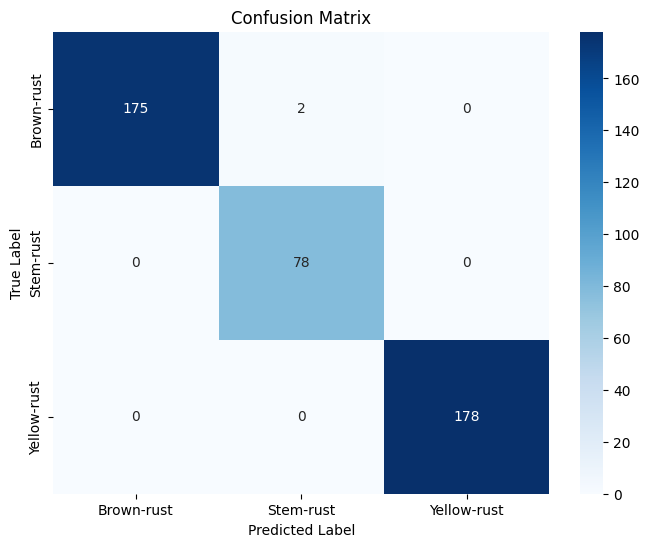

In [74]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Assurez-vous d'appeler le modèle correctement
            outputs = model(images, images)  # Remettre deux arguments
            
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = 100 * sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
class_names = ["Brown-rust", "Stem-rust", "Yellow-rust"]
evaluate_model(model, test_loader, class_names)


In [82]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Charger l'image
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")

# Définir les transformations (adaptées à votre modèle)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adapter à la taille d'entrée du modèle
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation (ajuster selon votre modèle)
])

# Appliquer les transformations
image = transform(image)
image = image.unsqueeze(0)  # Ajouter une dimension batch

# Déplacer l'image vers l'appareil (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

# Charger le modèle (s'assurer qu'il est en mode évaluation)
model.to(device)
model.eval()

# Prédiction
with torch.no_grad():
    output = model(image, image)  # ⚠️ Vérifiez si votre modèle prend deux entrées
    _, predicted = torch.max(output, 1)

# Liste des classes (modifier selon vos classes)
class_names = ["Brown-rust", "Stem-rust", "Yellow-rust"]
predicted_class = class_names[predicted.item()]

print(f"Classe prédite : {predicted_class}")


Classe prédite : Yellow-rust


In [83]:
torch.save(model.state_dict(), "RustClassification.pth")
print("Modèle sauvegardé sous 'RustClassification.pth'")


Modèle sauvegardé sous 'RustClassification.pth'
